In [30]:
import json
import ast
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder

from config import Config, MulticlassConfig
from preprocessing import (
    build_vocab, save_vocab, load_vocab,
    build_scaler, save_scaler, load_scaler,
    build_label_encoder, save_label_encoder, load_label_encoder,
    MalwareDataset
)
from model import BiLSTM
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings('ignore')

In [ ]:
mode = int(input("Pilih mode (1=binary, 2=multiclass): "))

if mode == 1:
    cfg = Config()
    model_name = "binary_model.pth"
    data_files = ["fitur_Benign.csv", "fitur_Malware.csv"]
    file_label_map = {
        "fitur_Benign.csv": 0,
        "fitur_Malware.csv": 1
    }
    print("Mode: binary")
elif mode == 2:
    cfg = MulticlassConfig()
    model_name = "multiclass_model.pth"
    data_files = [
        "Adware.csv",
        "Coinminer.csv",
        "Keylogger.csv",
        "Ransomware.csv",
        "Dropper.csv",
        "RAT.csv",
        "Botnet.csv",
        "Cryptominer.csv"
    ]
    file_label_map = {
        fname: os.path.splitext(fname)[0].lower()
        for fname in data_files
    }
    print("Mode: multiclass")

max_len = cfg.max_length
batch_size = cfg.batch_size
epochs = cfg.epochs
lr = cfg.learning_rate


Mode: binary


In [32]:
ARTIFACT_DIR = "artifacts"
VOCAB_PATH = os.path.join(ARTIFACT_DIR, "vocab.pkl")
SCALER_PATH = os.path.join(ARTIFACT_DIR, "scaler.pkl")
LABEL_ENCODER_PATH = os.path.join(ARTIFACT_DIR, "label_encoder.pkl")
MODEL_PATH = os.path.join(ARTIFACT_DIR, model_name)

In [ ]:
df_list = []
for fname in data_files:
    df_i = pd.read_csv(os.path.join(fname))
    df_i["label"] = file_label_map[fname]
    df_list.append(df_i)
df = pd.concat(df_list, ignore_index=True)

if mode == 2:
    merge_mapping = {
        "coinminer":"cryptominer",
        "stealer": "other",
    }

    df['label'] = df['label'].replace(merge_mapping)
    counts = df['label'].value_counts()
    print(counts)

sequence_cols = [
    "exec_processes_seq", "exec_paths_seq",
    "dns_queries_seq", "dns_types_seq",
    "udp_ports_seq", "udp_src_ports_seq", "udp_dst_ports_seq", "udp_sizes_seq", "udp_timestamps_seq",
    "hosts_seq",
    "sig_names_seq",
    "ttps_seq",
    "processes_seq", "process_states_seq", "injection_flags_seq", "parent_procid_seq", "start_ts_seq",
    "screenshot_scores_seq"
]

for col in sequence_cols:
    df[col] = df[col].apply(
        lambda x: ast.literal_eval(x)
                  if pd.notna(x) and isinstance(x, str) and x.startswith('[')
                  else []
    )

seqs = []
for _, row in df.iterrows():
    parts = []
    for col in sequence_cols:
        parts.extend(map(str, row[col]))
    seqs.append(";".join(parts))

numeric_cols = [
    "num_execs", "num_unique_execs",
    "num_dns_queries",
    "num_udp_packets",
    "num_hosts",
    "num_ttps",
    "num_processes"
]

nums = df[numeric_cols].fillna(0).values
labels = df['label'].tolist()

In [34]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import numpy as np

# 1. Gabung sequence
seqs = []
for _, row in df.iterrows():
    parts = []
    for col in sequence_cols:
        vals = row[col]
        # Pastikan vals adalah list/array dan tidak kosong
        if isinstance(vals, (list, np.ndarray)) and len(vals) > 0:
            # Tambahkan tiap elemen sebagai token (cast ke str utk safety)
            parts.extend(str(x) for x in vals)
    # Gabungkan semua token dengan delimiter ';'
    seqs.append(";".join(parts))

df["combined_seq"] = seqs

# 2. Encode label
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])

# 3. Hitung fitur‐fitur sequence
def extract_stats(s):
    toks = s.split(';') if s else []
    total = len(toks)
    unique = len(set(toks))
    diversity = unique/total if total>0 else 0
    return total, unique, diversity

stats = df['combined_seq'].apply(extract_stats)
df['seq_length'], df['seq_unique_count'], df['seq_diversity'] = zip(*stats)

# 4. Korelasi ketiga fitur itu dengan label
feat_cols = ['seq_length','seq_unique_count','seq_diversity']
corrs = df[feat_cols + ['label_enc']].corr()['label_enc'].drop('label_enc')
print("Sequence‐stats ↔ label correlations:")
print(corrs)

# 5. (Opsional) Korelasi token‐by‐token
#    Ambil top 10 token
all_tokens = Counter()
for s in df['combined_seq']:
    all_tokens.update(s.split(';'))
top_tokens = [t for t,_ in all_tokens.most_common(10)]

print("\nTop‐token ↔ label correlations:")
for token in top_tokens:
    col = f"count_{token}"
    df[col] = df['combined_seq'].apply(lambda s: s.split(';').count(token))
    if df[col].var()>0:
        print(f"{token:15s}: {df[[col,'label_enc']].corr().iloc[0,1]:.4f}")
    else:
        print(f"{token:15s}: no variance (skip)")



Sequence‐stats ↔ label correlations:
seq_length          0.913156
seq_unique_count    0.817119
seq_diversity       0.955820
Name: label_enc, dtype: float64

Top‐token ↔ label correlations:
53             : 0.8920
A              : 0.9001
137            : 0.9352
42             : 0.9492
34             : 0.8950
49             : 0.9834
settings-win.data.microsoft.com: 0.9834
sls.update.microsoft.com: 0.9730
137->137       : 0.9100
False          : 0.4075


In [35]:
from collections import Counter
import numpy as np

# 1. Hitung count per token seperti sebelumnya
all_tokens = Counter()
for s in df['combined_seq']:
    all_tokens.update(s.split(';'))
top_tokens = [t for t,_ in all_tokens.most_common(20)]

for token in top_tokens:
    df[f"count_{token}"] = df['combined_seq'].apply(lambda s: s.split(';').count(token))

# 2. Hitung korelasi dan simpan ke dict
corrs = {}
for token in top_tokens:
    col = f"count_{token}"
    if df[col].var() > 0:
        corrs[token] = df[col].corr(df['label_enc'])
    else:
        corrs[token] = np.nan

# 3. Sort dict by correlation descending
sorted_corrs = sorted(
    ((tok, r) for tok,r in corrs.items() if not np.isnan(r)),
    key=lambda x: x[1],
    reverse=True
)

# 4. Cetak top-10 berdasarkan korelasi
print("Top-10 tokens by label correlation:")
for tok, r in sorted_corrs[:10]:
    print(f"{tok:30s} ↔ {r:.4f}")


Top-10 tokens by label correlation:
insiderppe.cloudapp.net        ↔ 0.9975
settings-win.data.microsoft.com ↔ 0.9834
49                             ↔ 0.9834
sls.update.microsoft.com       ↔ 0.9730
1900                           ↔ 0.9500
42                             ↔ 0.9492
137                            ↔ 0.9352
dns.msftncsi.com               ↔ 0.9277
137->137                       ↔ 0.9100
A                              ↔ 0.9001


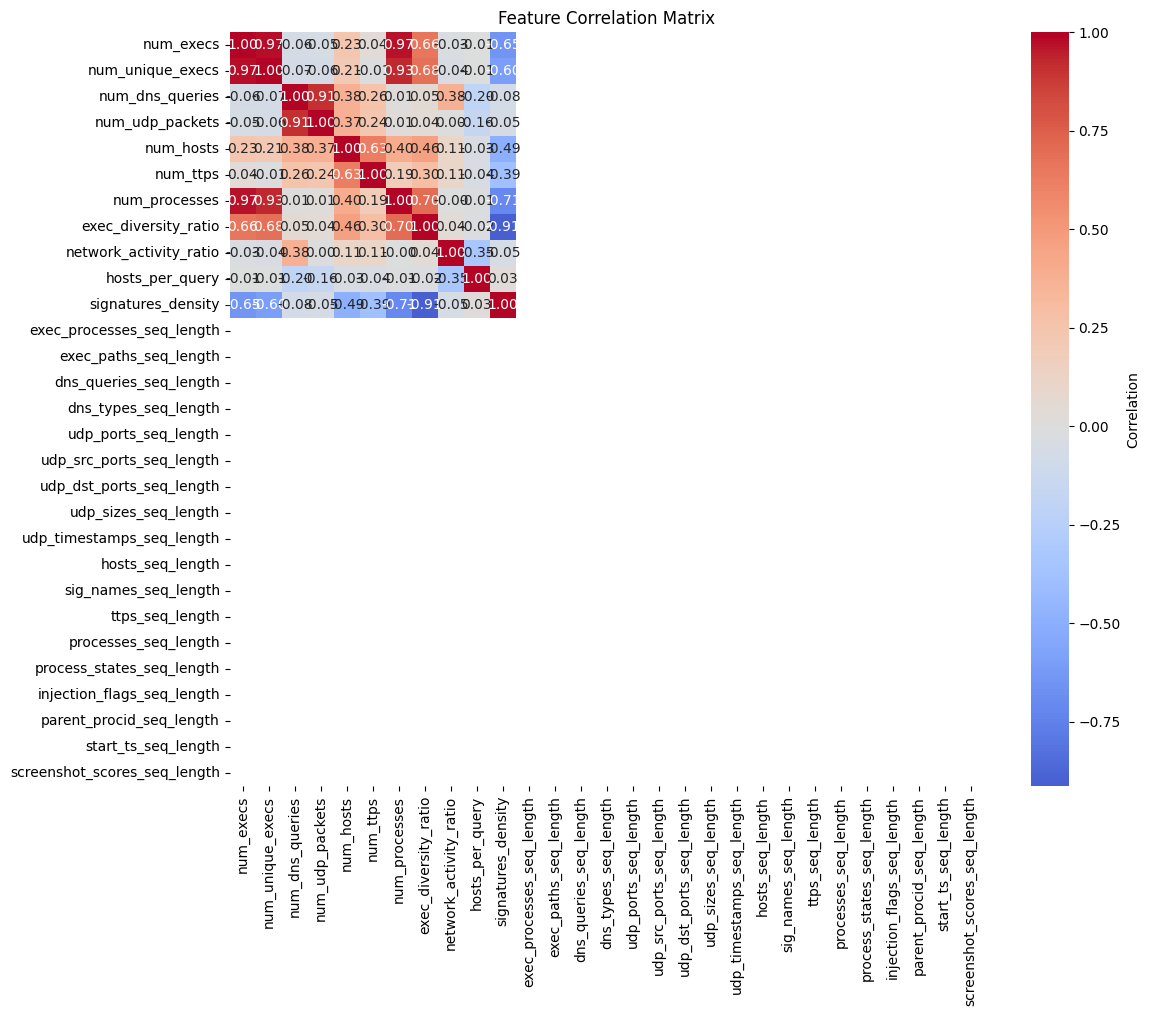


Highly correlated feature pairs (>0.7):
num_execs <-> num_unique_execs: 0.971
num_execs <-> num_processes: 0.966
num_unique_execs <-> num_processes: 0.930
num_dns_queries <-> num_udp_packets: 0.908
num_processes <-> signatures_density: -0.708
exec_diversity_ratio <-> signatures_density: -0.914

Analyzed 29 features:
- Original numeric: ['num_execs', 'num_unique_execs', 'num_dns_queries', 'num_udp_packets', 'num_hosts', 'num_ttps', 'num_processes', 'exec_diversity_ratio', 'network_activity_ratio', 'hosts_per_query', 'signatures_density']
- Sequence lengths: ['exec_processes_seq_length', 'exec_paths_seq_length', 'dns_queries_seq_length', 'dns_types_seq_length', 'udp_ports_seq_length', 'udp_src_ports_seq_length', 'udp_dst_ports_seq_length', 'udp_sizes_seq_length', 'udp_timestamps_seq_length', 'hosts_seq_length', 'sig_names_seq_length', 'ttps_seq_length', 'processes_seq_length', 'process_states_seq_length', 'injection_flags_seq_length', 'parent_procid_seq_length', 'start_ts_seq_length', '

In [36]:
df['hosts_seq_length'] = df['hosts_seq'].astype(str).str.split(';').str.len()
df['sig_names_seq_length'] = df['sig_names_seq'].astype(str).str.split(';').str.len()

df['exec_diversity_ratio'] = df['num_unique_execs'] / (df['num_execs'] + 1)
df['network_activity_ratio'] = df['num_dns_queries'] / (df['num_udp_packets'] + 1)
df['hosts_per_query'] = df['hosts_seq_length'] / (df['num_dns_queries'] + 1)
df['signatures_density'] = df['sig_names_seq_length'] / (df['num_execs'] + 1)

numeric_cols.extend(['exec_diversity_ratio', 'network_activity_ratio', 
                    'hosts_per_query', 'signatures_density'])

correlation_features = numeric_cols.copy()

for col in sequence_cols:
    try:
        # Hitung panjang sequence sebagai feature
        df[f'{col}_length'] = df[col].astype(str).str.split(';').str.len()
        correlation_features.append(f'{col}_length')
    except:
        pass

features_df = df[correlation_features].fillna(0)
corr_matrix = features_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("\nHighly correlated feature pairs (>0.7):")
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            print(f"{corr_matrix.columns[i]} <-> {corr_matrix.columns[j]}: {corr_val:.3f}")
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

if not high_corr_pairs:
    print("No highly correlated pairs found (threshold: 0.7)")

print(f"\nAnalyzed {len(correlation_features)} features:")
print(f"- Original numeric: {numeric_cols}")
print(f"- Sequence lengths: {[f'{col}_length' for col in sequence_cols]}")
print("="*50)

In [37]:
# Keep the most informative features
selected_features = [
    "num_execs",         # total eksekusi
    "num_dns_queries",   # total query DNS
    "num_udp_packets",   # total paket UDP
    "num_hosts",         # jumlah host unik
    "num_ttps",          # jumlah teknik MITRE
    "num_processes",     # jumlah proses
]

# Drop redundant features
features_to_drop = [
    "num_unique_execs",
    "exec_diversity_ratio",
    "network_activity_ratio",
    "hosts_per_query",
    "signatures_density",
    # serta semua sequence‑length (karena kita pakai raw seq)
    "exec_processes_seq_length",
    "exec_paths_seq_length",
    "dns_queries_seq_length",
    "udp_ports_seq_length",
    "hosts_seq_length",
    "sig_names_seq_length",
]

# Update numeric_cols for training
numeric_cols = selected_features

print(f"Selected features ({len(selected_features)}): {selected_features}")
print(f"Dropped features ({len(features_to_drop)}): {features_to_drop}")
print("="*50)

cfg.numeric_dim = len(selected_features)  # Should be 6
print(f"Updated numeric_dim to: {cfg.numeric_dim}")

Selected features (6): ['num_execs', 'num_dns_queries', 'num_udp_packets', 'num_hosts', 'num_ttps', 'num_processes']
Dropped features (11): ['num_unique_execs', 'exec_diversity_ratio', 'network_activity_ratio', 'hosts_per_query', 'signatures_density', 'exec_processes_seq_length', 'exec_paths_seq_length', 'dns_queries_seq_length', 'udp_ports_seq_length', 'hosts_seq_length', 'sig_names_seq_length']
Updated numeric_dim to: 6


In [38]:
nums = df[selected_features].fillna(0).values

s_tr, s_te, n_tr, n_te, y_tr, y_te = train_test_split(
    seqs, nums, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

s_tr, s_val, n_tr, n_val, y_tr, y_val = train_test_split(
    s_tr, n_tr, y_tr,
    test_size=0.1,
    random_state=42,
    stratify=y_tr
)

In [ ]:
if mode == 1:
    vocab = build_vocab(s_tr)
    save_vocab(vocab, VOCAB_PATH)
    scaler = build_scaler(n_tr)
    save_scaler(scaler, SCALER_PATH)
    class_weights_tensor = None
else:
    le = build_label_encoder(y_tr)
    save_label_encoder(le, LABEL_ENCODER_PATH)
    class_weights = compute_class_weight(
        'balanced', 
        classes=np.unique(y_tr), 
        y=y_tr
    )
    class_weights_tensor = torch.FloatTensor(class_weights).to(cfg.device)
    print(f"Class weights shape: {class_weights_tensor.shape}")
    print(f"Expected classes from config: {cfg.num_classes}")

Class weights shape: torch.Size([2])
Expected classes from config: 2


In [40]:
vocab = load_vocab(VOCAB_PATH)
scaler = load_scaler(SCALER_PATH)
le = load_label_encoder(LABEL_ENCODER_PATH)

train_ds = MalwareDataset(s_tr, n_tr, y_tr, vocab, scaler, le, cfg.max_length)
val_ds   = MalwareDataset(s_val, n_val, y_val, vocab, scaler, le, cfg.max_length)
test_ds  = MalwareDataset(s_te, n_te, y_te, vocab, scaler, le, cfg.max_length)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size)
test_loader  = DataLoader(test_ds,  batch_size=cfg.batch_size)

print(f"Datasets → train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")

Datasets → train: 1782, val: 198, test: 496


In [41]:
device = cfg.device
model = BiLSTM(vocab_size=len(vocab), cfg=cfg).to(cfg.device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate)

In [42]:
best_val_acc = 0.0
for ep in range(epochs):
    model.train()
    train_loss = correct = total = 0
    for batch in train_loader:
        seq, nums, lbl = batch["sequence"], batch["numeric"], batch["label"]
        seq, nums, lbl = seq.to(device), nums.to(device), lbl.to(device)

        optimizer.zero_grad()
        logits = model(seq, nums)
        loss = criterion(logits, lbl)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * seq.size(0)
        if cfg.num_classes == 2:
            probs = torch.softmax(logits, dim=1)[:,1]
            preds = (probs > cfg.threshold).long()
        else:
            preds = logits.argmax(dim=1)
        correct   += (preds == lbl).sum().item()
        total     += seq.size(0)

    train_loss /= total
    train_acc   = 100 * correct / total

    # Validation
    model.eval()
    val_loss = correct = total = 0
    with torch.no_grad():
        for batch in val_loader:                # ← pakai val_loader
            seq, nums, lbl = batch["sequence"], batch["numeric"], batch["label"]
            seq, nums, lbl = seq.to(device), nums.to(device), lbl.to(device)

            logits = model(seq, nums)
            loss = criterion(logits, lbl)
            val_loss += loss.item() * seq.size(0)

            # untuk binary, threshold, kalau multiclass argmax
            if cfg.num_classes == 2:
                probs = torch.softmax(logits, dim=1)[:,1]
                preds = (probs > cfg.threshold).long()
            else:
                preds = logits.argmax(dim=1)

            correct += (preds == lbl).sum().item()
            total   += seq.size(0)

    val_loss /= total
    val_acc   = 100 * correct / total

    print(f"Epoch {ep+1}/{epochs} | Train: {train_acc:.1f}% ({train_loss:.4f}) | Val: {val_acc:.1f}% ({val_loss:.4f})")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_PATH)
        tag = "Binary" if cfg.num_classes==2 else "Multiclass"
        print(f"{tag} model saved to '{ARTIFACT_DIR}/' folder (best so far)")

Epoch 1/20 | Train: 88.5% (1.4217) | Val: 93.9% (0.3969)
Binary model saved to 'artifacts/' folder (best so far)
Epoch 2/20 | Train: 99.7% (0.0688) | Val: 93.4% (1.0383)
Epoch 3/20 | Train: 99.4% (0.0530) | Val: 95.5% (0.4592)
Binary model saved to 'artifacts/' folder (best so far)
Epoch 4/20 | Train: 99.7% (0.0123) | Val: 100.0% (0.0006)
Binary model saved to 'artifacts/' folder (best so far)
Epoch 5/20 | Train: 99.8% (0.0087) | Val: 99.5% (0.0535)
Epoch 6/20 | Train: 99.8% (0.0196) | Val: 94.4% (1.1996)
Epoch 7/20 | Train: 99.9% (0.0037) | Val: 93.4% (1.9406)
Epoch 8/20 | Train: 100.0% (0.0000) | Val: 93.9% (1.8318)
Epoch 9/20 | Train: 99.7% (0.0608) | Val: 93.9% (1.8578)
Epoch 10/20 | Train: 100.0% (0.0000) | Val: 93.9% (2.1542)
Epoch 11/20 | Train: 100.0% (0.0000) | Val: 93.9% (2.1551)
Epoch 12/20 | Train: 99.9% (0.0060) | Val: 93.4% (4.0980)
Epoch 13/20 | Train: 99.9% (0.0022) | Val: 93.9% (3.2310)
Epoch 14/20 | Train: 100.0% (0.0000) | Val: 93.9% (3.0441)
Epoch 15/20 | Train: 100

In [43]:
print(f"Training done! Best Val accuracy: {best_val_acc:.1f}%")
torch.save(model.state_dict(), MODEL_PATH)
print(f"Training done! Model saved to {MODEL_PATH}")
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Training done! Best Val accuracy: 100.0%
Training done! Model saved to artifacts\binary_model.pth
Model saved to artifacts\binary_model.pth


– Dataset size: 496
– Collected preds: 496, labels: 496

Test Accuracy : 95.77%
Test F1-macro : 0.9576


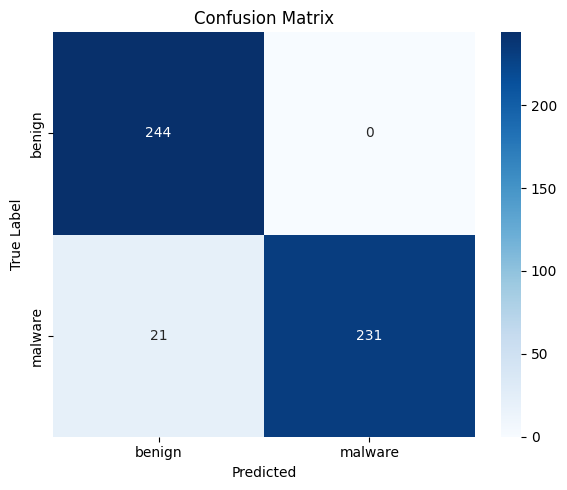


Classification Report:
              precision    recall  f1-score   support

      benign       0.92      1.00      0.96       244
     malware       1.00      0.92      0.96       252

    accuracy                           0.96       496
   macro avg       0.96      0.96      0.96       496
weighted avg       0.96      0.96      0.96       496



In [44]:
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        seq = batch["sequence"].to(device)
        num = batch["numeric"].to(device)
        lbl = batch["label"].to(device)

        logits = model(seq, num) if hasattr(model, "classifier") else model(seq)

        if cfg.num_classes == 2:
            probs = torch.softmax(logits, dim=1)[:, 1]    # P(class=1)
            preds = (probs > cfg.threshold).long()
        else:
            preds = logits.argmax(dim=1)

        all_preds .extend(preds.cpu().numpy())
        all_labels.extend(lbl.cpu().numpy())

print(f"– Dataset size: {len(test_loader.dataset)}")
print(f"– Collected preds: {len(all_preds)}, labels: {len(all_labels)}")

acc      = accuracy_score(all_labels, all_preds) * 100
f1_macro = f1_score(all_labels, all_preds, average="macro")
print(f"\nTest Accuracy : {acc:.2f}%")
print(f"Test F1-macro : {f1_macro:.4f}")

cm = confusion_matrix(all_labels, all_preds)
names = (le.classes_ if cfg.num_classes > 2 else ["benign","malware"])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=names, yticklabels=names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=names))